# Artificial Intelligence - 2nd Assignment

- Firstly, we import the necessary libraries, packages and methods.

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
# Machine Learning
from sklearn.svm import SVC
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_curve,roc_curve,roc_auc_score
from sklearn.metrics import auc
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler 
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics
from sklearn import linear_model,preprocessing
from sklearn import tree
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, roc_curve, auc
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from prettytable import PrettyTable

<hr>
<br>

## 1. Dataset Analysis and Review


Attributes:
 
Attribute | Type | Properties | Discrete vs Continuous |
| - | - | - | - |
| Distance from home | Ratio |  Distinctness, Order, Meaningful differences and Meaningful ratios | Continuous |
| Distance from last transaction | Ratio | Distinctness, Order, Meaningful differences and Meaningful ratios | Continuous |
| Ratio of purchased price to median purchased price | Ratio |  Distinctness, Order, Meaningful differences and Meaningful ratios | Continuous |
| Repeat Retailer | Nominal (binary) | Distinctness | Discrete |
| Used chip (used credit card) | Nominal (binary) | Distinctness | Discrete | 
| Used pin (used pin number) | Nominal (binary) | Distinctness | Discrete |
| Online Order | Nominal (binary) | Distinctness | Discrete |


In [44]:
dataFrame = pd.read_csv('../files/card_transdata.csv')
dataFrame.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0


<hr>
<br>

- You can now find basic statistics about our problem.

In [45]:
dataFrame = dataFrame.sample(5000)
dataFrame.describe()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,26.155262,4.997257,1.894642,0.889000,0.349000,0.101600,0.654200,0.091200
std,57.528804,22.550223,3.088272,0.314164,0.476702,0.302152,0.475676,0.287922
min,0.085419,0.001729,0.024318,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.020209,0.299218,0.486625,1.000000,0.000000,0.000000,0.000000,0.000000
50%,10.339759,0.998585,1.041118,1.000000,0.000000,0.000000,1.000000,0.000000
75%,26.068661,3.301563,2.108035,1.000000,1.000000,0.000000,1.000000,0.000000
max,1824.079840,720.882584,66.282390,1.000000,1.000000,1.000000,1.000000,1.000000


<hr>
<br>

## Data Preprocessing

- First, we are checking if there are any duplicated data.
- If yes, we remove duplicated objects.
- For this specific dataset, there isn't any duplicated data as it can be watch in the following:

In [46]:
length = len(dataFrame)
dataFrame.drop_duplicates(keep = False)
cleanedDups = len(dataFrame)

print("Original dataset length: ", length)
print("Number of dups: ", length - cleanedDups)

Original dataset length:  5000
Number of dups:  0


- Secondly, we detect outliers.

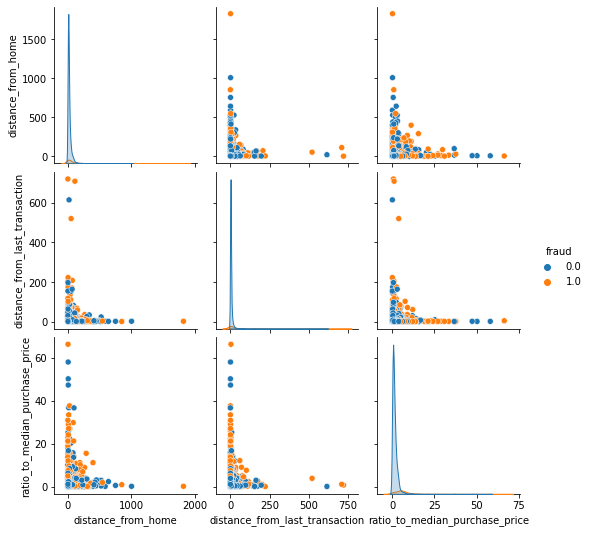

In [47]:
%matplotlib inline
sns.pairplot(dataFrame, vars =["distance_from_home", "distance_from_last_transaction", "ratio_to_median_purchase_price"], hue = 'fraud')

- If there are any outliers for the given dataset, we remove them.

In [48]:
#remove outliers
#dataFrame['distance_from_home'] = np.where((dataFrame['distance_from_home']<1900 & dataFrame['fraud'] == 0) |dataFrame['fraud'] == 1)
#dataFrame = fraud.loc[(dataFrame['fraud'] == 1) | (dataFrame['distance_from_last_transaction'] >= 10)]
#dataFrame = fraud.loc[(dataFrame['fraud'] == 0) | (dataFrame['ratio_to_median_purchase_price'] >= 10)]

#%matplotlib inline

#sns.pairplot(dataFrame, vars =["distance_from_home", "distance_from_last_transaction", "ratio_to_median_purchase_price"], hue = 'fraud')

- The last step of data preprocessing for our problem is removing "NA" or null values.

In [49]:
print(dataFrame.isna().sum())
print(dataFrame.isnull().sum())
dataFrame = pd.read_csv('../files/card_transdata.csv', na_values=['NA'])
dataFrame.dropna()

distance_from_home                0
distance_from_last_transaction    0
ratio_to_median_purchase_price    0
repeat_retailer                   0
used_chip                         0
used_pin_number                   0
online_order                      0
fraud                             0
dtype: int64
distance_from_home                0
distance_from_last_transaction    0
ratio_to_median_purchase_price    0
repeat_retailer                   0
used_chip                         0
used_pin_number                   0
online_order                      0
fraud                             0
dtype: int64


,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...
999995,2.207101,0.112651,1.626798,1.0,1.0,0.0,0.0,0.0
999996,19.872726,2.683904,2.778303,1.0,1.0,0.0,0.0,0.0
999997,2.914857,1.472687,0.218075,1.0,1.0,0.0,1.0,0.0
999998,4.258729,0.242023,0.475822,1.0,0.0,0.0,1.0,0.0


<hr>
<br>

- In this step, we use a sample of our dataset since the given one is too long, reaching 1000000 objects.
- After that, we create two new datasets: one only containing fraudlent transactions (fraud attribute = 1) and another contaning only non-fraudlent transactions (fraud attribute = 0)

In [50]:
#No fraud (class == 0) meaning legit transactions
#Fraud (class == 1) meaning fraudulent transactions

#Creating new data frames for No fraud and Fraud cases
no_fraud=dataFrame[dataFrame.fraud == 0]
fraud=dataFrame[dataFrame.fraud == 1]

#Resampling the original dataset with 10,000 datapoints
no_fraud_resample=no_fraud.sample(n=1000)
fraud_resample=fraud.sample(n=1000)

#Creating new dataset consisting of equal class occurence 
data=pd.concat([no_fraud_resample,fraud_resample],axis=0)

In [51]:
#Splitting the dataset

#Creating dataframe for target
target=data['fraud']

#Creating dataframe for features
features=data.drop(columns=['fraud'],axis=1)


train_features,test_features,train_labels,test_labels = train_test_split(features,target,stratify=target,shuffle=True,random_state=43)

In [52]:
#Standardising the dataset
scale=MinMaxScaler().fit(train_features)
train_features_scaled=scale.transform(train_features)
test_features_scaled=scale.transform(test_features)

<hr>
<br>

## Algorithms and Model Training

### Random Forest

In [53]:
startTime = time.time()


data_all=[] #Creating empty list to store model evaluation values
model_name = 'Random Forest'
model = RandomForestClassifier()
param_rf={
    "n_estimators": range(2,15,2),
    "max_features": range(1,7),
    "max_depth": range(1,10)
}


random_rf = RandomizedSearchCV(estimator = model, 
                                param_distributions = param_rf, 
                                n_iter = 15, 
                                cv = 10,
                                scoring = 'accuracy', 
                                verbose = 1, 
                                n_jobs = -1,
                                random_state = 1)

random_rf.fit(train_features, train_labels)


model = random_rf.best_estimator_
crossval = cross_val_score(model,
                            train_features,
                            train_labels,
                            cv = 5,
                            scoring = 'accuracy')

scores = np.mean(crossval)

test_pred = model.predict(test_features)
test_recall = recall_score(test_labels, 
                            test_pred, 
                            pos_label = 1)
fpr, tpr, thresholds = roc_curve(test_labels, 
                                test_pred, 
                                pos_label = 1)
test_auc = auc(fpr, tpr)

endTime = time.time()

print('Train acc:', round(scores * 100, 2), '%')
print('Test acc:', round(accuracy_score(test_labels, test_pred) * 100, 2), '%')
print('Best n_estimators:', random_rf.best_estimator_.get_params()['n_estimators'])
print('Best max_features:', random_rf.best_estimator_.get_params()['max_features'])
print('Best max_depth:', random_rf.best_estimator_.get_params()['max_depth'])



Fitting 10 folds for each of 15 candidates, totalling 150 fits
Train acc: 99.13 %
Test acc: 98.8 %
Best n_estimators: 14
Best max_features: 5
Best max_depth: 6


#### Random Forest Confusion Matrix

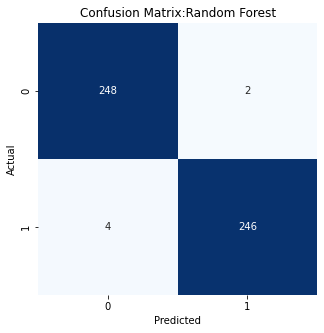

              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99       250
         1.0       0.99      0.98      0.99       250

    accuracy                           0.99       500
   macro avg       0.99      0.99      0.99       500
weighted avg       0.99      0.99      0.99       500



In [54]:
test_pred = model.predict(test_features)
cm = confusion_matrix(test_labels, test_pred)
clr = classification_report(test_labels, test_pred)
plt.figure(figsize=(5, 5))
sns.heatmap(cm, 
            annot = True, 
            vmin = 0, 
            fmt = 'g', 
            cbar = False, 
            cmap = 'Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix:Random Forest")
plt.show()
print(clr)

if accuracy_score(test_labels, test_pred) - scores < 1:
    result_model = 'Good Model'
    data_all.append([model,
                    scores,
                    accuracy_score(test_labels, test_pred),
                    test_recall, 
                    test_auc,
                    result_model])
else:
    result_model = 'Bad Model'
    data_all.append([model,
                    scores,
                    accuracy_score(test_labels, test_pred),
                    test_recall,
                    test_auc,
                    result_model])

#### Random Forest Running Time

In [55]:
print("Running time: ", endTime-startTime)

Running time:  1.2373335361480713


<hr>
<br>

### Support Vector Machine

In [56]:
startTime = time.time()

data_all=[] #Creating empty list to store model evaluation values
model_name='SVM'
model= SVC()
param_svm={
    "C":[100,10,1,0.1],
    "gamma": [10,1,0.1,0.001],
    "kernel": ['rbf']
    }

random_svm=RandomizedSearchCV(estimator=model, param_distributions=param_svm, n_iter = 15 , scoring='accuracy', cv = 10, verbose=2, n_jobs=-1,random_state=43)
random_svm.fit(train_features_scaled,train_labels)

model=random_svm.best_estimator_
crossval = cross_val_score(model,train_features_scaled,train_labels,cv=5,scoring='accuracy')
scores = np.mean(crossval)

test_pred=model.predict(test_features_scaled)
test_recall = recall_score(test_labels, test_pred, pos_label=1)
fpr, tpr, thresholds = roc_curve(test_labels, test_pred, pos_label=1)
test_auc = auc(fpr, tpr)


endTime = time.time()

print('Train accuracy:',round(scores*100,2),'%')
print('Test accuracy:',round(accuracy_score(test_labels,test_pred)*100,2),'%')
print('Best C:',random_svm.best_estimator_.get_params()['C'])
print('Best gamma:',random_svm.best_estimator_.get_params()['gamma'])
print('Best kernel:',random_svm.best_estimator_.get_params()['kernel']) 



Fitting 10 folds for each of 15 candidates, totalling 150 fits
[CV] END .....................C=0.1, gamma=0.001, kernel=rbf; total time=   0.2s
[CV] END .....................C=0.1, gamma=0.001, kernel=rbf; total time=   0.2s
[CV] END .....................C=0.1, gamma=0.001, kernel=rbf; total time=   0.1s
[CV] END .....................C=0.1, gamma=0.001, kernel=rbf; total time=   0.2s
[CV] END .....................C=0.1, gamma=0.001, kernel=rbf; total time=   0.2s[CV] END .....................C=0.1, gamma=0.001, kernel=rbf; total time=   0.2s

[CV] END ..........................C=1, gamma=10, kernel=rbf; total time=   0.1s
[CV] END .....................C=0.1, gamma=0.001, kernel=rbf; total time=   0.2s
[CV] END ..........................C=1, gamma=10, kernel=rbf; total time=   0.1s
[CV] END .....................C=0.1, gamma=0.001, kernel=rbf; total time=   0.3s
[CV] END ..........................C=1, gamma=10, kernel=rbf; total time=   0.1s
[CV] END .....................C=0.1, gamma=0.0

#### Support Vector Machine Confusion Matrix

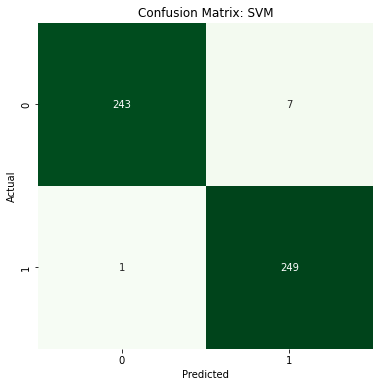

Classification Report:

               precision    recall  f1-score   support

         0.0       1.00      0.97      0.98       250
         1.0       0.97      1.00      0.98       250

    accuracy                           0.98       500
   macro avg       0.98      0.98      0.98       500
weighted avg       0.98      0.98      0.98       500



In [57]:
test_pred=model.predict(test_features_scaled)
cm = confusion_matrix(test_labels, test_pred)
clr = classification_report(test_labels, test_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cbar=False, cmap='Greens')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix: SVM")
plt.show()
print("Classification Report:\n\n", clr)

if accuracy_score(test_labels,test_pred)-scores <1:
    result_model='Good Model'
    data_all.append([model_name,scores,accuracy_score(test_labels,test_pred),test_recall,test_auc,result_model])
else:
    result_model='Failed'
    data_all.append([model_name,scores,accuracy_score(test_labels,test_pred),test_recall,test_auc,result_model])

Defining a Function for Train and Test split - split is done on 80% train and 20% test (can be altered in test_size value). Initially done including all features.

#### Support Vector Machine Running Time

In [58]:
print("Running time: ", endTime-startTime)

Running time:  2.48140287399292


<hr>
<br>

### Decision Tree

In [59]:
startTime = time.time()

des_tree_model = DecisionTreeClassifier()
drawing= des_tree_model.fit(train_features, train_labels)
y_test_pred = des_tree_model.predict(test_features)
y_train_pred = des_tree_model.predict(train_features)
Accuracy_Test=accuracy_score(test_labels, y_test_pred) * 100
Accuracy_Test= str(Accuracy_Test) + " %"
Accuracy_Train=accuracy_score(train_labels, y_train_pred) * 100
Accuracy_Train= str(Accuracy_Train) + " %"
Train_Data_Score=des_tree_model.score(train_features, train_labels) * 100
Train_Data_Score= str(Train_Data_Score) + " %"


#Construction of confusion matrix
confmat_train = confusion_matrix(y_train_pred, train_labels)
confmat_test =  confusion_matrix(y_test_pred, test_labels)
print ("\nConfusion matrix of Train Data\n", confmat_train)
print ("\nConfusion matrix of Test Data\n", confmat_test)
total=sum(sum(confmat_test))


#Calculation of Specificity
#Specificity = TN/(TN+FP)
sp = confmat_test[1,1]/(confmat_test[1,0]+confmat_test[1,1]) * 100
sp= str(sp) + " %"


#Calculation of sensitivity
#Sensitivity= TP/(TP+FN)
sensi = confmat_test[0,0]/(confmat_test[0,0]+confmat_test[0,1]) * 100
sensi= str(sensi) + " %"



myTable = PrettyTable(["Peformance Paramters", "Value"]) 
#Insert rows
myTable.add_row(["Accuracy of Test Data",Accuracy_Test]) 
myTable.add_row(["Accuracy of Train Data", Accuracy_Train]) 
myTable.add_row(["Data score of Train Data",Train_Data_Score]) 
myTable.add_row(["Specificity of the confusion matrix",sp]) 
myTable.add_row(["Sensitivity of the confusion matrix",sensi])

endTime = time.time()

#print Output
print(myTable)


Confusion matrix of Train Data
 [[750   0]
 [  0 750]]

Confusion matrix of Test Data
 [[250   2]
 [  0 248]]
+-------------------------------------+---------------------+
|         Peformance Paramters        |        Value        |
+-------------------------------------+---------------------+
|        Accuracy of Test Data        |        99.6 %       |
|        Accuracy of Train Data       |       100.0 %       |
|       Data score of Train Data      |       100.0 %       |
| Specificity of the confusion matrix |       100.0 %       |
| Sensitivity of the confusion matrix | 99.20634920634922 % |
+-------------------------------------+---------------------+


#### Deision Tree Confusion Matrix

In [60]:
# Confusion matrix of the Decision Tree
import matplotlib.pyplot as plt
%matplotlib inline  

def plot_confusionmat(cm, lab, test_or_train):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    f = ax.matshow(cm, cmap=plt.cm.turbo)
    plt.title('Confusion Matrix of the ' + test_or_train +' Decision Tree \n')
    fig.colorbar(f)
    ax.set_xticklabels([''] + lab)
    ax.set_yticklabels([''] + lab)
    plt.xlabel('Predicted Values')
    plt.ylabel('True Values')
    s = [['TP','FN'], ['FP', 'TN']]
    for k in range(2):
        for l in range(2):
            plt.text(l,k, str(cm[k][l]))
    plt.show()

/tmp/ipykernel_30591/1066701508.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + lab)
/tmp/ipykernel_30591/1066701508.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + lab)


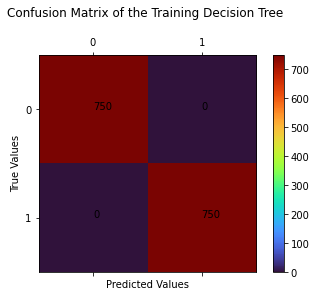

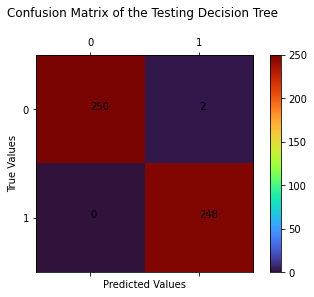

In [61]:
plot_confusionmat(confmat_train, ["0","1"], "Training")
plot_confusionmat(confmat_test, ["0","1"], "Testing")

#### Decision Tree Drawing

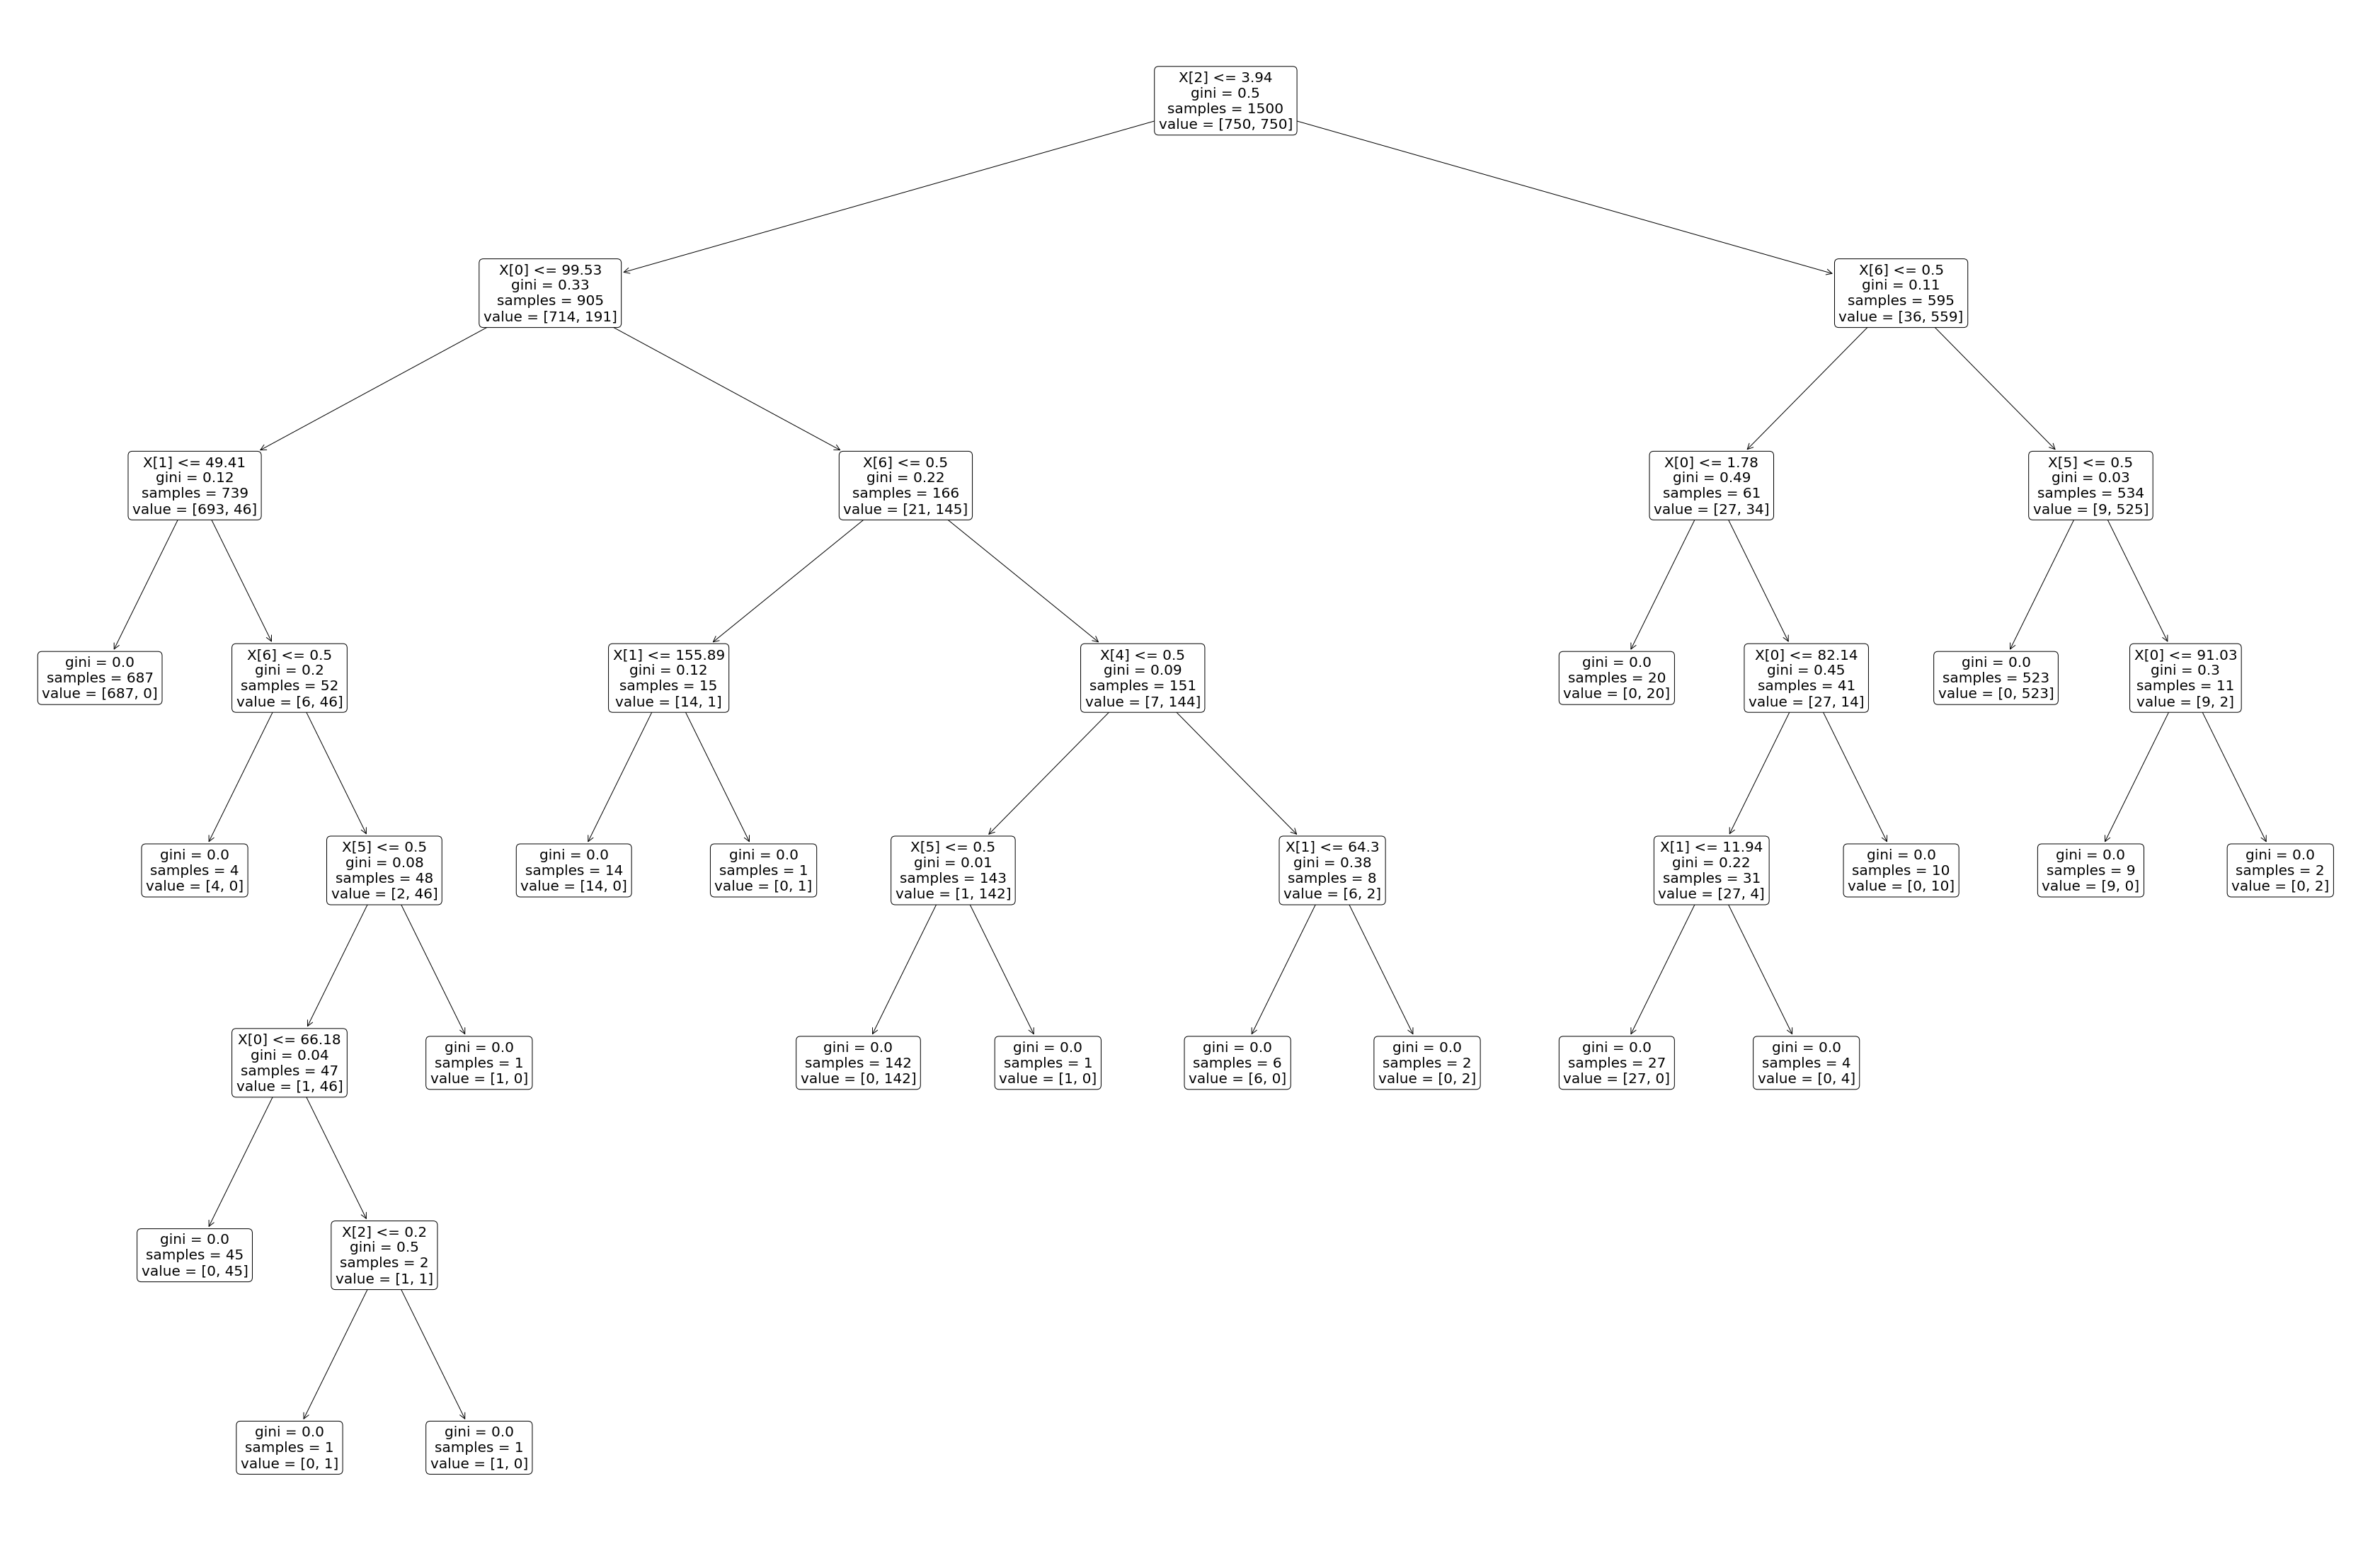

In [62]:
plt.figure(figsize=[60,40])
tree.plot_tree(des_tree_model,fontsize=20, rounded=True,impurity=True, precision=2)
#tree.plot_tree(drawing,fontsize=20, rounded=True,impurity=True, precision=2)
plt.show()

<hr>
<br>

### Logisitic Regression

In [63]:
startTime = time.time()

# List of continuous features
conts = list(dataFrame.columns[:3])

# List of categorical (0/1) features
cats = list(dataFrame.columns[3:-1])

transformations = [('continuous', StandardScaler(), conts), ('categorical', OrdinalEncoder(), cats)]
pipeline = ColumnTransformer(transformations)

In [64]:
train_transformed = pipeline.fit_transform(train_features)

In [65]:
baseline = LogisticRegression(max_iter=110)

In [66]:
baseline.fit(train_transformed, train_labels)

LogisticRegression(max_iter=110)

In [67]:
test_transformed = pipeline.transform(test_features)

baseline_preds = baseline.predict(test_transformed)

In [68]:
baseline.score(test_transformed, test_labels)

0.95

In [69]:
confusion_matrix(test_labels, baseline_preds)

array([[237,  13],
       [ 12, 238]])

In [70]:
precision_score(test_labels, baseline_preds)

0.9482071713147411

In [71]:
recall_score(test_labels, baseline_preds)

0.952

In [72]:
svc_clf = SVC(kernel='rbf', gamma='auto')

In [73]:
svc_clf.fit(train_transformed, train_labels)

SVC(gamma='auto')

In [74]:
svc_clf.score(test_transformed, test_labels)

0.974

In [75]:
svc_preds = svc_clf.predict(test_transformed)

#### Logistic Regression Confusion Matrix

In [76]:
confusion_matrix(test_labels, svc_preds)

array([[239,  11],
       [  2, 248]])

In [77]:
precision_score(test_labels, svc_preds)

0.9575289575289575

In [78]:
recall_score(test_labels, svc_preds)

endTime = time.time()

#### Logistic Regression Running Time

In [79]:
print("Running time: ", endTime-startTime)

Running time:  1.9877150058746338


<hr>
<br>

## Ensemble Classification

In [80]:
models=['SVM','Logisitic Regression','Random Forest', 'Decision Tree']
pd_scores=pd.DataFrame(data_all,columns=['model','train score','test score','test recall','test_auc','Remark'])
print(pd_scores)

  model  train score  test score  test recall  test_auc      Remark
0   SVM     0.973333       0.984        0.996     0.984  Good Model
